In [98]:
import torch
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from spiffyplots import MultiPanel

import time

batchsize = 50
n_filters = 10
n_pre = 6

dt = 1e-3
timesteps = 200
spikesteps = timesteps - 150

tau_f = 10e-3
decay_f = np.exp(-dt / tau_f)
scl_f = 1 - decay_f

spiketrain = np.zeros((batchsize, n_pre, timesteps))

# Random input spikes
spike_idx = np.random.randint(0, spikesteps, size=(batchsize, n_pre, 10))
for i in range(batchsize):
    for j in range(n_pre):
        spiketrain[i, j, spike_idx[i, j]] = 1

### Option 1: Filter update simultaneously (for-loop)

In [99]:
filters = np.zeros((batchsize, n_pre, n_filters))
rec_filters1 = np.zeros((batchsize, n_pre, n_filters, timesteps))

# Start timer
start = time.time()

for step in range(0, timesteps):
    preact = spiketrain[:, :, step]

    new_filters = np.zeros((batchsize, n_pre, n_filters))
    update = preact

    for i in range(n_filters):
        new_filters[:, :, i] = decay_f * filters[:, :, i] + update
        update = new_filters[:, :, i] * scl_f

    filters = new_filters

    # Record filters
    rec_filters1[:, :, :, step] = new_filters

# End timer
end = time.time()
print("Computation time (NUMPY): ", end - start)

Computation time (NUMPY):  0.022664785385131836


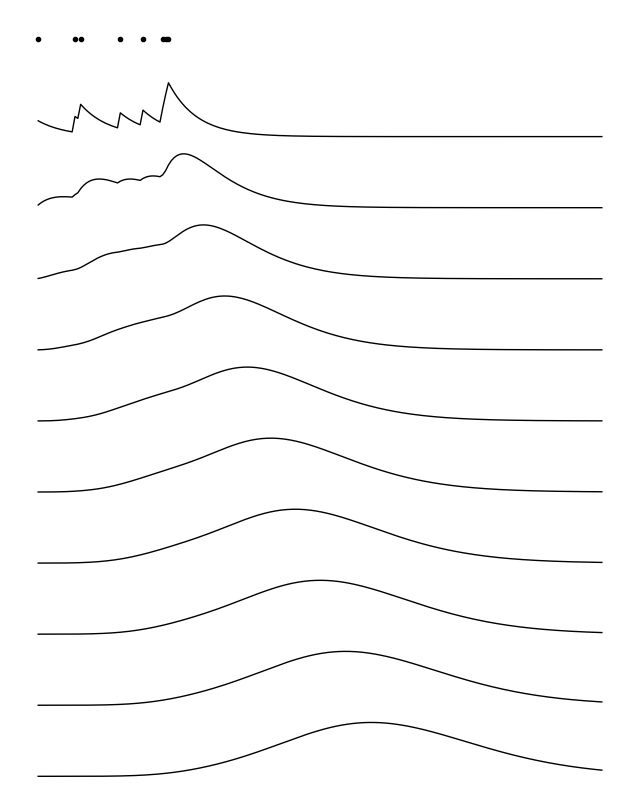

In [100]:
fig = MultiPanel(grid=[1] * (n_filters + 1), figsize=(8, 10), sharex=True)

fig.panels[0].plot(spiketrain[0, 0], "-o", color="black", lw=0, ms=3)
fig.panels[0].set_ylim(0.5, 1.5)
fig.panels[0].axis("off")

for filt_idx in range(n_filters):
    fig.panels[filt_idx + 1].plot(
        rec_filters1[0, 0, filt_idx, :].T, color="black", lw=1
    )
    fig.panels[filt_idx + 1].axis("off")

### Option 2: Update delayed (update matrix)

In [101]:
filters = np.zeros((batchsize, n_pre, n_filters))
rec_filters2 = np.zeros((batchsize, n_pre, n_filters, timesteps))

# Update matrix
A = np.zeros((n_filters, n_filters))

# Set diagonal to decay factor for each matrix A[i,:,:]
np.fill_diagonal(A, decay_f)

# Set the diagonal with offset 1 to scaling factor
for i in range(n_filters - 1):
    A[i, i + 1] = scl_f

# Start timer
start = time.time()

for step in range(0, timesteps):
    preact = spiketrain[:, :, step]

    # Update all filters
    filters = np.dot(filters, A)

    # Add spike to first filters
    filters[:, :, 0] += preact

    # Record filters
    rec_filters2[:, :, :, step] = filters

# End timer
end = time.time()
print("Computation time (NUMPY): ", end - start)

Computation time (NUMPY):  0.014606952667236328


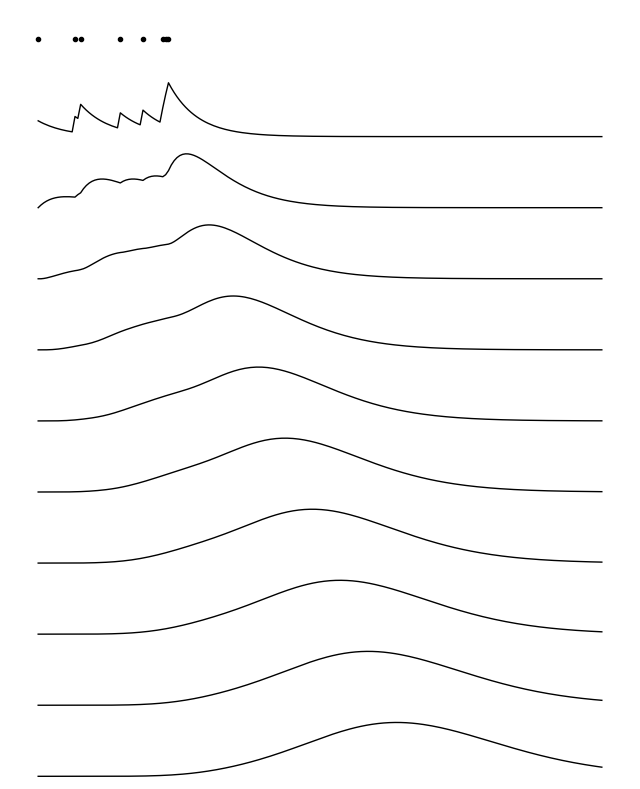

In [102]:
fig = MultiPanel(grid=[1] * (n_filters + 1), figsize=(8, 10), sharex=True)

fig.panels[0].plot(spiketrain[0, 0], "-o", color="black", lw=0, ms=3)
fig.panels[0].set_ylim(0.5, 1.5)
fig.panels[0].axis("off")

for filt_idx in range(n_filters):
    fig.panels[filt_idx + 1].plot(
        rec_filters2[0, 0, filt_idx, :].T, color="black", lw=1
    )
    fig.panels[filt_idx + 1].axis("off")

### Comparison

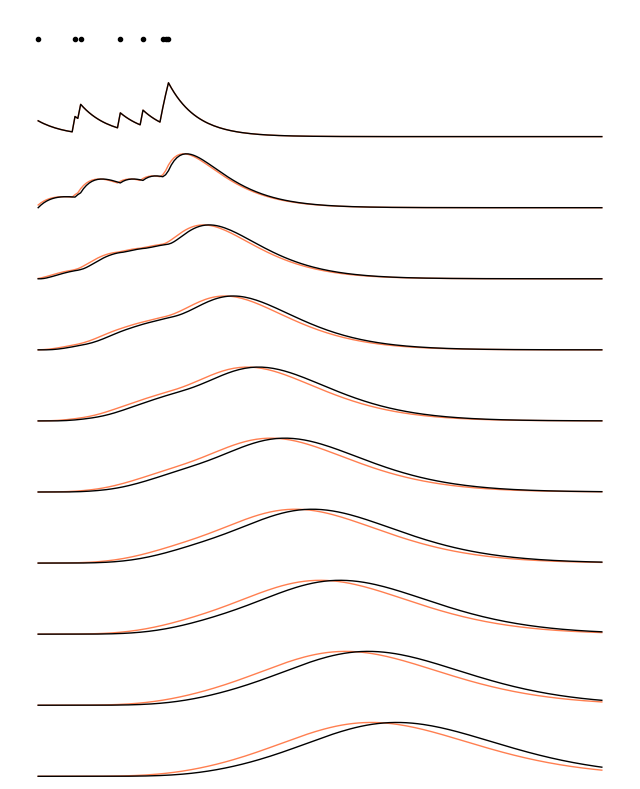

In [103]:
fig = MultiPanel(grid=[1] * (n_filters + 1), figsize=(8, 10), sharex=True)

fig.panels[0].plot(spiketrain[0, 0], "-o", color="black", lw=0, ms=3)
fig.panels[0].set_ylim(0.5, 1.5)
fig.panels[0].axis("off")

for filt_idx in range(n_filters):
    fig.panels[filt_idx + 1].plot(
        rec_filters1[0, 0, filt_idx, :].T, color="coral", lw=1
    )
    fig.panels[filt_idx + 1].plot(
        rec_filters2[0, 0, filt_idx, :].T, color="black", lw=1
    )
    fig.panels[filt_idx + 1].axis("off")